# Farm Parcel Analysis by Climate Zones and Canopy Cover (2014 Drought)

# Author: Judith Bross  


# ## Project Overview
# This notebook analyzes farm parcels in San Diego County by dividing them into climate zones.  
# The workflow includes:

# 1. **Climate Zone Classification**  
# 2. **Canopy Cover Features by Height**  
# 3. **Historical Drought Analysis (2014)**  


# ## Goals
# - Identify canopy structural features across parcels in a representative climate zone.  
# - Evaluate how canopy cover by height was affected during the 2014 drought.  
# - Provide parcel-level insights into resilience and vulnerability under historical drought conditions.

In [ ]:
# Setup & imports (consolidated)
from pathlib import Path
import re
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [47]:
# Load the agricultural parcels shapefile
shapefile_dir = Path(r"C:\Users\jbros\OneDrive\Documents\SanDiego_RemoteSensing\Agricultural_Commodity_2020_shapefile")
parcels_gdf = gpd.read_file(shapefile_dir / "Agricultural_Commodity_2020.shp")

# Check for duplicate site_ids in the shapefile
duplicate_sites = parcels_gdf['site_id'].value_counts()
duplicate_sites = duplicate_sites[duplicate_sites > 1].index.tolist()

print(f"Found {len(duplicate_sites)} site_ids with multiple polygons")
print(f"Total duplicate polygons: {sum(parcels_gdf['site_id'].isin(duplicate_sites))}")

# Create a copy of the original site_id column before any modifications
parcels_gdf['original_name'] = parcels_gdf['site_id']

# Create a function to rename duplicates
def rename_duplicates(df):
    if len(df) > 1:
        # Add suffix (_A, _B, etc)
        suffixes = [f"_{chr(65+i)}" for i in range(len(df))]
        df['site_id'] = df['original_name'] + suffixes
    return df

# Apply the renaming only to duplicate sites
if len(duplicate_sites) > 0:
    # Create a mask for duplicates
    mask = parcels_gdf['original_name'].isin(duplicate_sites)
    
    # Group by original_name instead of site_id
    grouped = parcels_gdf[mask].groupby('original_name', group_keys=False)
    
    # Apply the renaming
    renamed = grouped.apply(rename_duplicates)
    
    # Update the original dataframe
    parcels_gdf.loc[mask] = renamed
    
    # Verify changes
    print("\nSample of renamed parcels:")
    sample = parcels_gdf[parcels_gdf['original_name'].isin(duplicate_sites)]
    print(sample[['original_name', 'site_id', 'geometry']].head(10))
    
    # Print full list of duplicates
    print("\nComplete list of renamed parcels:")
    for site_id in duplicate_sites:
        count = sum(sample['original_name'] == site_id)
        renamed = sample[sample['original_name'] == site_id]['site_id'].tolist()
        print(f"{site_id}: {count} polygons → {', '.join(renamed)}")
else:
    print("No duplicate site_ids found in the shapefile")



# Verify no duplicates remain
remaining_duplicates = parcels_gdf['site_id'].duplicated().sum()
print(f"Remaining duplicates after processing: {remaining_duplicates}")

Found 429 site_ids with multiple polygons
Total duplicate polygons: 887


C:\Users\jbros\AppData\Local\Temp\ipykernel_18384\220551978.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  renamed = grouped.apply(rename_duplicates)



Sample of renamed parcels:
   original_name   site_id                                           geometry
28        AVQ001  AVQ001_A  POLYGON ((6345662.298 1984098.227, 6346832.829...
29        BKD002  BKD002_A  POLYGON ((6252986.186 2039595.908, 6253429.05 ...
30        BKD003  BKD003_A  POLYGON ((6252463.652 2039872.9, 6252438.89 20...
31        BKD016  BKD016_A  POLYGON ((6256218.888 2040961.993, 6256215.267...
32        BWD006  BWD006_A  POLYGON ((6248668.293 2038521.174, 6249240.223...
33        EAZ015  EAZ015_A  POLYGON ((6247020.943 2041024.606, 6247065.468...
34        ACY226  ACY226_A  POLYGON ((6261256.494 2042864.365, 6261240.036...
35        EAZ012  EAZ012_A  POLYGON ((6247668.019 2039157.093, 6247943.138...
36        EAZ011  EAZ011_A  POLYGON ((6247638.913 2039186.798, 6244817.876...
37        EAZ016  EAZ016_A  POLYGON ((6253654.014 2046373.524, 6253669.27 ...

Complete list of renamed parcels:
01: 8 polygons → 01_A, 01_B, 01_C, 01_D, 01_E, 01_F, 01_G, 01_H
ATC027: 5 polyg

In [49]:
#read and align

cz_fp = r"C:\Users\jbros\OneDrive\Documents\BuildingClimateZones_CEC_2015_1387197077153995162\Building_Climate_Zones.shp"
sd_kml = r"C:\Users\jbros\OneDrive\Documents\San_Diego_County_Boundary.kml"
ag_dir = Path(r"C:\Users\jbros\OneDrive\Documents\SanDiego_RemoteSensing\Agricultural_Commodity_2020_shapefile")
ag_fp = ag_dir / "Agricultural_Commodity_2020.shp"

cz = gpd.read_file(cz_fp)
sd = gpd.read_file(sd_kml, driver="KML")
parcels = gpd.read_file(ag_fp)

sd = sd.to_crs(cz.crs)
parcels = parcels.to_crs(cz.crs)

  BZone  parcel_count
0    10          1511
1     7           751
2    14            63
3    15            24
Top zone: 10 (1511 parcels)


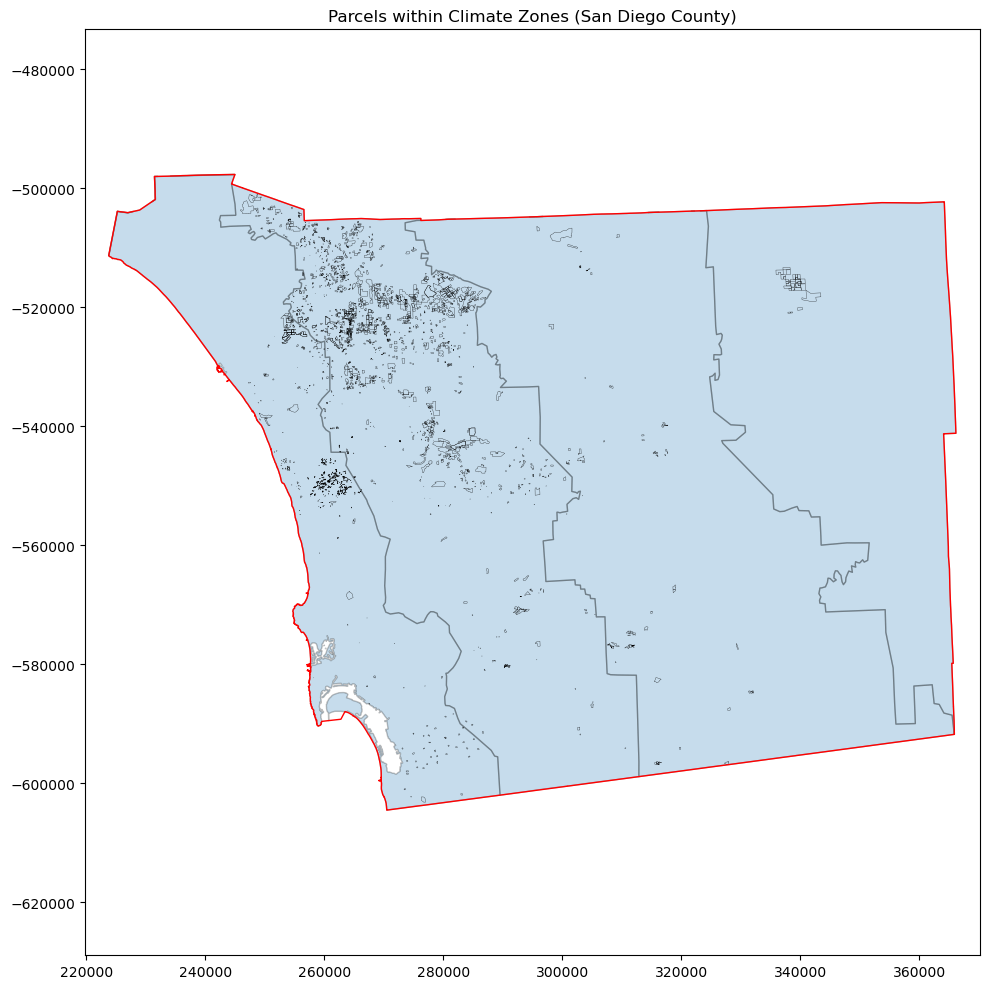

In [33]:
# clip zones to county and attach zone to each parcel (within)
cz_clip = gpd.overlay(cz, sd, how="intersection")

zone_candidates = [c for c in cz_clip.columns if re.search(r"(zone|clim)", c, re.I)]
zone_col = max(zone_candidates, key=lambda c: cz_clip[c].nunique()) if zone_candidates else None
assert zone_col is not None, f"No zone-like column found. Columns: {list(cz_clip.columns)}"

parcels_with_zone = gpd.sjoin(
    parcels,
    cz_clip[[zone_col, "geometry"]],
    how="inner",
    predicate="within"
).drop(columns=["index_right"])

zone_counts = (parcels_with_zone.groupby(zone_col)
               .size()
               .reset_index(name="parcel_count")
               .sort_values("parcel_count", ascending=False)
               .reset_index(drop=True))
top = zone_counts.iloc[0]
print(zone_counts.head(10))
print(f"Top zone: {top[zone_col]} ({int(top['parcel_count'])} parcels)")

#  maps
ax = cz_clip.plot(figsize=(10,10), alpha=0.25, edgecolor="k")
parcels_with_zone.plot(ax=ax, linewidth=0.2, edgecolor="black", facecolor="none")
sd.boundary.plot(ax=ax, color="red", linewidth=1)
plt.title("Parcels within Climate Zones (San Diego County)")
plt.axis("equal"); plt.tight_layout()

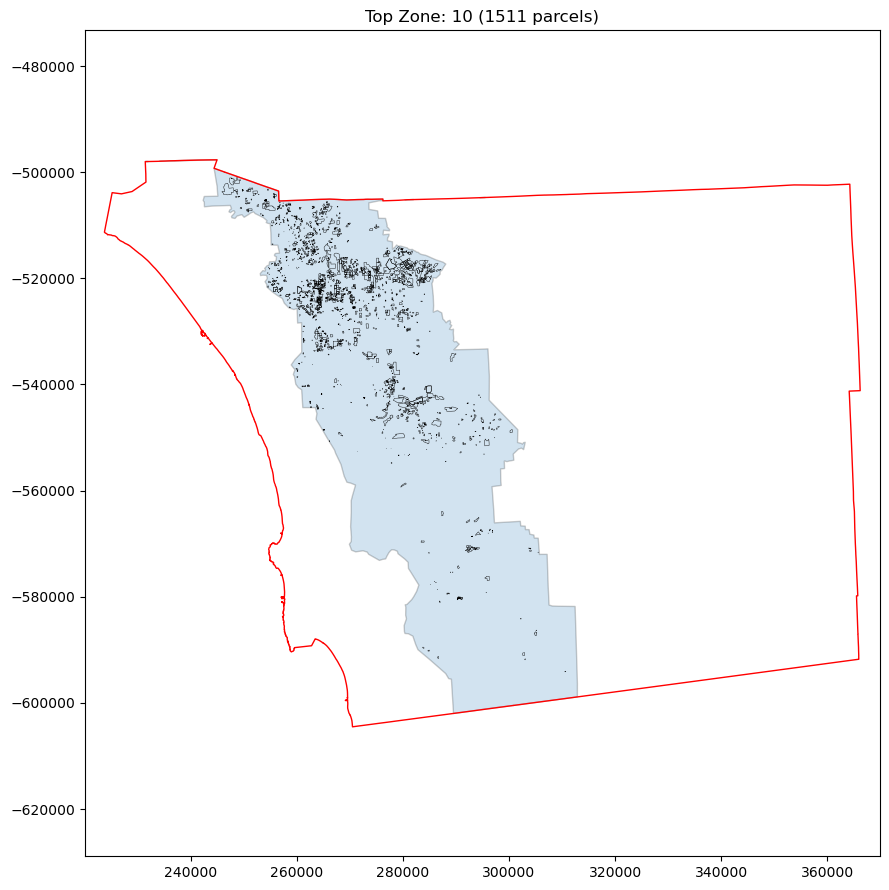

In [35]:
#map on top zone
val = top[zone_col]
focus_zone = cz_clip.loc[cz_clip[zone_col] == val]
focus_parcels = parcels_with_zone.loc[parcels_with_zone[zone_col] == val]

ax = focus_zone.plot(figsize=(9,9), alpha=0.2, edgecolor="k")
focus_parcels.plot(ax=ax, linewidth=0.3, edgecolor="black", facecolor="none")
sd.boundary.plot(ax=ax, color="red", linewidth=1)
plt.title(f"Top Zone: {val} ({int(top['parcel_count'])} parcels)")
plt.axis("equal"); plt.tight_layout()

In [ ]:
### naip imagery

In [2]:
# Setup & imports
from pathlib import Path
import os
import pandas as pd
import rasterio as rio
from shapely.geometry import box
from shapely.ops import transform as shp_transform
from pyproj import Transformer, CRS
import matplotlib.pyplot as plt  

# Set paths (edit for your machine)
naip_dir = Path(r"E:\NAIP")
zone10_tif = Path(r"E:\NAIP\nDSM_Veg2014_02-011.tif")

assert naip_dir.exists(), f"Folder not found: {naip_dir}"
assert zone10_tif.exists(), f"Zone 10 raster not found: {zone10_tif}"



In [4]:
# get bounds polygon from a raster; reproject polygons; area in equal-area CRS
def raster_bounds_polygon(tif_path):
    with rio.open(tif_path) as ds:
        b = ds.bounds
        crs = ds.crs
    return box(b.left, b.bottom, b.right, b.top), CRS.from_user_input(crs)

def reproject_polygon(poly, src_crs, dst_crs):
    transformer = Transformer.from_crs(src_crs, dst_crs, always_xy=True)
    return shp_transform(lambda x, y: transformer.transform(x, y), poly)

def area_m2(poly, src_crs):
    # Project to California Albers (EPSG:3310) for stable area (meters^2)
    ea = CRS.from_epsg(3310)
    poly_ea = reproject_polygon(poly, src_crs, ea)
    return float(poly_ea.area)


In [6]:
# Scan folder and compute overlap with Zone 10 raster (by extent)
zone_poly, zone_crs = raster_bounds_polygon(zone10_tif)

rows = []
errors = []

for tif in sorted(naip_dir.glob("*.tif")):
    try:
        with rio.open(tif) as ds:
            tif_crs = CRS.from_user_input(ds.crs)
            tif_poly = box(*ds.bounds)
    except Exception as e:
        errors.append({"path": str(tif), "error": str(e)})
        continue

    # Reproject zone polygon to the TIF's CRS for geometric test
    zone_poly_in_tif = reproject_polygon(zone_poly, zone_crs, tif_crs)

    inter = zone_poly_in_tif.intersection(tif_poly)
    has_overlap = not inter.is_empty

    if has_overlap:
        # Areas
        zone_area = area_m2(zone_poly_in_tif, tif_crs)  # zone area expressed in tif CRS then area in EPSG:3310
        tif_area  = area_m2(tif_poly, tif_crs)
        inter_area = area_m2(inter, tif_crs)

        rows.append({
            "file": tif.name,
            "path": str(tif),
            "overlap_m2": inter_area,
            "pct_of_zone10_%": (inter_area / zone_area * 100.0) if zone_area > 0 else 0.0,
            "pct_of_tile_%": (inter_area / tif_area * 100.0) if tif_area > 0 else 0.0,
        })

# Make a DataFrame
overlap_df = pd.DataFrame(rows).sort_values(["overlap_m2", "file"], ascending=[False, True]).reset_index(drop=True)

print(f"Found {len(overlap_df)} files overlapping Zone 10.")
display(overlap_df.head(20))  # preview


Found 5 files overlapping Zone 10.


,file,path,overlap_m2,pct_of_zone10_%,pct_of_tile_%
0,nDSM_Veg2014_02-011.tif,E:\NAIP\nDSM_Veg2014_02-011.tif,6.042133e+08,100.000000,100.000000
1,nDSM_Veg2014_03-013.tif,E:\NAIP\nDSM_Veg2014_03-013.tif,4.580859e+06,0.758153,0.575271
2,nDSM_Veg2014_06-001.tif,E:\NAIP\nDSM_Veg2014_06-001.tif,3.628062e+06,0.600460,0.566157
3,nDSM_Veg2014_05-002.tif,E:\NAIP\nDSM_Veg2014_05-002.tif,3.752979e+02,0.000062,0.000068
4,nDSM_Veg2014_07-004.tif,E:\NAIP\nDSM_Veg2014_07-004.tif,3.442747e+02,0.000057,0.000041


In [16]:
pip install pyforest


  Using cached pyforest-1.1.2-py2.py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [18]:
# Cell 1 — setup (pyforest + geo stack)
# pyforest gives lazy access to pd, np, plt, etc.
import pyforest  # pd, np, plt, sns, etc. will import on first use

import geopandas as gpd
import rasterio as rio
import rasterio.mask
from rasterio.features import geometry_mask
from shapely.geometry import box, shape, mapping
from shapely.ops import unary_union
from shapely import wkt
from pyproj import CRS, Transformer
from pathlib import Path

# Cell 2 — paths & params (EDIT paths for your machine if needed)
# Parcel polygons (Agricultural parcels)
parcels_shp = Path(r"C:\Users\jbros\OneDrive\Documents\SanDiego_RemoteSensing\Agricultural_Commodity_2020_shapefile\Agricultural_Commodity_2020.shp")

# Zone 10 vegetation height raster (nDSM or veg height)
zone10_tif = Path(r"E:\NAIP\nDSM_Veg2014_02-011.tif")

# Height bins (meters): [0-2), [2-4), ..., [18-20]; last bin is closed on the right
bin_edges = np.arange(0, 22, 2)  # 0,2,4,...,20
bin_labels = [f"{bin_edges[i]}–{bin_edges[i+1]} m" for i in range(len(bin_edges)-1)]

assert parcels_shp.exists(), f"Parcels not found: {parcels_shp}"
assert zone10_tif.exists(), f"Zone 10 raster not found: {zone10_tif}"



<IPython.core.display.Javascript object>

In [20]:
# Cell 3 — find the largest parcel polygon intersecting Zone 10 raster extent
# - Read zone raster bounds as polygon
# - Read parcels, reproject to raster CRS
# - Intersect, compute intersection area, pick largest

with rio.open(zone10_tif) as zds:
    z_crs = CRS.from_user_input(zds.crs)
    z_bounds = box(*zds.bounds)

parcels = gpd.read_file(parcels_shp)
if parcels.crs is None:
    raise ValueError("Parcels shapefile has no CRS; set it before proceeding.")
parcels_z = parcels.to_crs(z_crs.to_string())

# Filter parcels that actually intersect the zone raster extent
parcels_inter = parcels_z[parcels_z.geometry.intersects(z_bounds)].copy()
parcels_inter["inter_geom"] = parcels_inter.geometry.intersection(z_bounds)

# Compute area of intersection in a stable equal-area CRS for CA
ea = CRS.from_epsg(3310)
parcels_inter_ea = parcels_inter.set_geometry(parcels_inter["inter_geom"]).to_crs(ea.to_string())
parcels_inter_ea["inter_area_m2"] = parcels_inter_ea.area

# Pick the single largest intersecting polygon by area within the zone extent
largest_row = parcels_inter_ea.loc[parcels_inter_ea["inter_area_m2"].idxmax()].copy()

# Keep original geometries in zone CRS for clipping
largest_geom_zone_crs = parcels_inter.loc[largest_row.name, "inter_geom"]
largest_parcel_attrs = parcels.loc[largest_row.name, parcels.columns.difference(["geometry"])].to_dict()

print("Selected parcel (largest intersecting Zone 10):")
print({k: largest_parcel_attrs.get(k) for k in ["site_id", "permit_num", "site_name", "commodity"] if k in largest_parcel_attrs})
print(f"Intersection area (m²): {largest_row['inter_area_m2']:.0f}")


Selected parcel (largest intersecting Zone 10):
{'site_id': 'CFI035', 'permit_num': '37P3203', 'site_name': '12921 MCNALLY RD, VALLEY CENTER', 'commodity': 'GRAPEFRUIT, LEMON, ORANGE, TANGELO, TANGERINE, AVOCADO'}
Intersection area (m²): 3148444


In [22]:
# Cell 4 — clip Zone 10 height raster to largest polygon & prepare data
# - Clip with geometry
# - Build valid mask (exclude nodata + negative)
# - Compute pixel area (assumes projected CRS in meters)

with rio.open(zone10_tif) as zds:
    if not CRS.from_user_input(zds.crs).is_projected:
        raise ValueError("Zone 10 raster CRS is geographic; reproject to a meter-based CRS before area calcs.")
    clipped_arr, clipped_transform = rasterio.mask.mask(
        zds,
        [mapping(largest_geom_zone_crs)],
        crop=True,
        filled=True,
        nodata=zds.nodata
    )
    # single band expected; if two-band veg (active/dormant), pick band 1 by default
    if clipped_arr.ndim == 3:
        # prefer first band as "active" height if stack
        hgt = clipped_arr[0]
    else:
        hgt = clipped_arr

    nodata = zds.nodata
    # Valid = finite & (not nodata) & >= 0
    valid = np.isfinite(hgt)
    if nodata is not None:
        valid &= (hgt != nodata)
    valid &= (hgt >= 0)

    hgt_valid = hgt[valid]

    # Pixel area (m²) from affine transform
    px_area_m2 = abs(zds.transform.a) * abs(zds.transform.e)

# Polygon (parcel) area in m² (use equal-area)
parcel_area_m2 = parcels_inter.loc[largest_row.name, "inter_geom"]
parcel_area_m2 = gpd.GeoSeries([parcel_area_m2], crs=z_crs.to_string()).to_crs(ea.to_string()).area.iloc[0]

total_valid_area_m2 = hgt_valid.size * px_area_m2

print(f"Valid veg pixels: {hgt_valid.size:,}")
print(f"Pixel area (m²): {px_area_m2:.3f}")
print(f"Total vegetated area in parcel (m²): {total_valid_area_m2:,.0f}")
print(f"Parcel intersection area (m²): {parcel_area_m2:,.0f}")


<IPython.core.display.Javascript object>

Valid veg pixels: 950,431
Pixel area (m²): 1.000
Total vegetated area in parcel (m²): 950,431
Parcel intersection area (m²): 3,148,444


In [24]:
# Cell 5 — canopy coverage by height bins (0–2, 2–4, ..., 18–20 m)
# - Histogram into bins
# - Area per bin (m²) and percents over parcel area & over vegetated area

# Histogram (last bin closed on right)
counts, edges = np.histogram(hgt_valid, bins=bin_edges)
# Make last bin include values == 20 exactly (if any)
counts[-1] += np.sum(hgt_valid == bin_edges[-1])

area_m2 = counts * px_area_m2
pct_of_parcel = (area_m2 / parcel_area_m2 * 100.0) if parcel_area_m2 > 0 else np.zeros_like(area_m2)
pct_of_veg = (area_m2 / total_valid_area_m2 * 100.0) if total_valid_area_m2 > 0 else np.zeros_like(area_m2)

canopy_df = pd.DataFrame({
    "height_bin": bin_labels,
    "pixel_count": counts,
    "area_m2": area_m2,
    "pct_of_parcel_%": pct_of_parcel,
    "pct_of_veg_%": pct_of_veg
})

# Add a >20 m diagnostic (not requested, but useful to confirm tail)
gt20_count = int(np.sum(hgt_valid > bin_edges[-1]))
if gt20_count > 0:
    gt20_row = pd.DataFrame({
        "height_bin": ["> 20 m"],
        "pixel_count": [gt20_count],
        "area_m2": [gt20_count * px_area_m2],
        "pct_of_parcel_%": [gt20_count * px_area_m2 / parcel_area_m2 * 100.0],
        "pct_of_veg_%": [gt20_count * px_area_m2 / total_valid_area_m2 * 100.0],
    })
    canopy_df = pd.concat([canopy_df, gt20_row], ignore_index=True)

canopy_df


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,height_bin,pixel_count,area_m2,pct_of_parcel_%,pct_of_veg_%
0,0–2 m,396956,396956.0,12.608007,41.765894
1,2–4 m,100143,100143.0,3.180714,10.536588
2,4–6 m,103551,103551.0,3.288958,10.895162
3,6–8 m,122882,122882.0,3.902944,12.929082
4,8–10 m,117506,117506.0,3.732193,12.363444
5,10–12 m,67510,67510.0,2.144234,7.103093
6,12–14 m,21892,21892.0,0.695328,2.303376
7,14–16 m,6825,6825.0,0.216774,0.718095
8,16–18 m,3496,3496.0,0.111039,0.367833
9,18–20 m,2582,2582.0,0.082009,0.271666


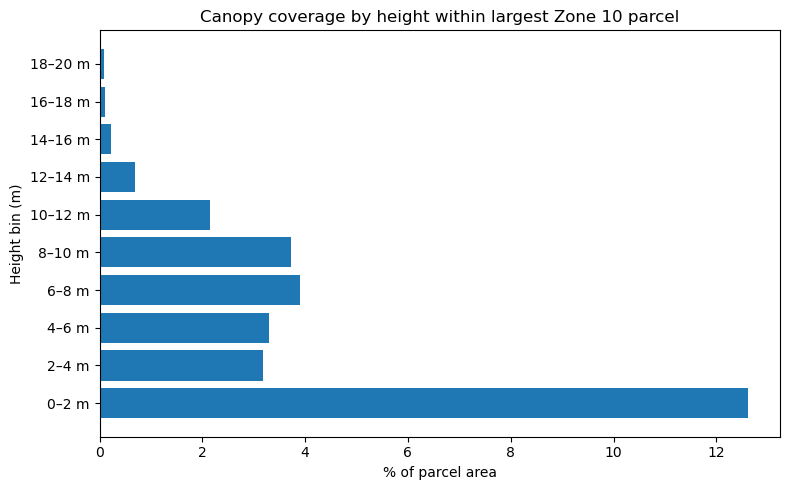

In [26]:
# Cell 6 — horizontal bar chart (ascending by height)
# Shows % of parcel area covered by each height bin
plot_df = canopy_df[canopy_df["height_bin"] != "> 20 m"] if (canopy_df["height_bin"] == "> 20 m").any() else canopy_df.copy()

plt.figure(figsize=(8, 5))
plt.barh(plot_df["height_bin"], plot_df["pct_of_parcel_%"])
plt.xlabel("% of parcel area")
plt.ylabel("Height bin (m)")
plt.title("Canopy coverage by height within largest Zone 10 parcel")
plt.tight_layout()


In [36]:
# HS0 — reload DSM clip + quick stats (robust to NaNs)
from pathlib import Path
import numpy as np
import rasterio as rio
from rasterio.mask import mask

# prefer the saved clip; else clip on the fly from zone10_tif
if 'clipped_tif_path' in globals() and Path(clipped_tif_path).exists():
    src_path = Path(clipped_tif_path)
    with rio.open(src_path) as src:
        Z = src.read(1).astype("float32")
        T = src.transform
        nodata = src.nodata
        z_crs = src.crs
else:
    src_path = Path(zone10_tif)
    with rio.open(src_path) as src:
        arr, T = mask(src, [largest_geom_zone_crs.__geo_interface__], crop=True, filled=True, nodata=src.nodata)
        Z = arr[0].astype("float32")
        nodata = src.nodata
        z_crs = src.crs

valid = np.isfinite(Z)
if nodata is not None:
    valid &= (Z != nodata)
valid &= (Z >= 0)

print("shape:", Z.shape, "valid_px:", int(valid.sum()))
if valid.any():
    print("min/max (valid):", float(np.nanmin(Z[valid])), float(np.nanmax(Z[valid])))
else:
    raise ValueError("No valid pixels found in the DSM clip.")



shape: (4909, 2335) valid_px: 950431
min/max (valid): 0.0 41.260833740234375


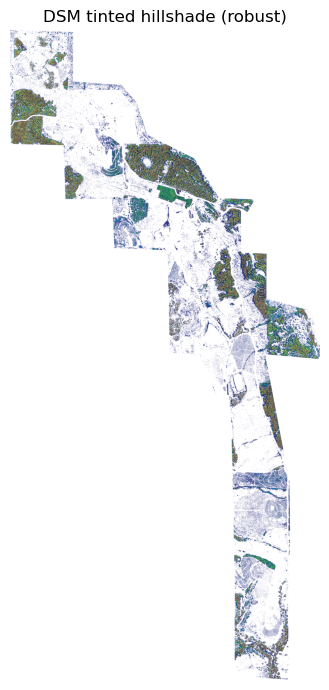

In [40]:
# HS2 — tinted hillshade (robust blend; no NaN warnings)
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource, Normalize
import numpy as np

norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
base_rgb = plt.cm.terrain(norm(Zf))[:, :, :3]    # RGB from DSM heights (filled)
hill = hs                                        # reuse hillshade from HS1 (0..1)

rgb = base_rgb * hill[..., None]                 # modulate colors by shade
alpha = valid.astype(float)                      # 1 inside parcel, 0 outside
rgba = np.dstack([rgb, alpha])

fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(rgba)
ax.set_axis_off()
ax.set_title("DSM tinted hillshade (robust)")
plt.tight_layout()


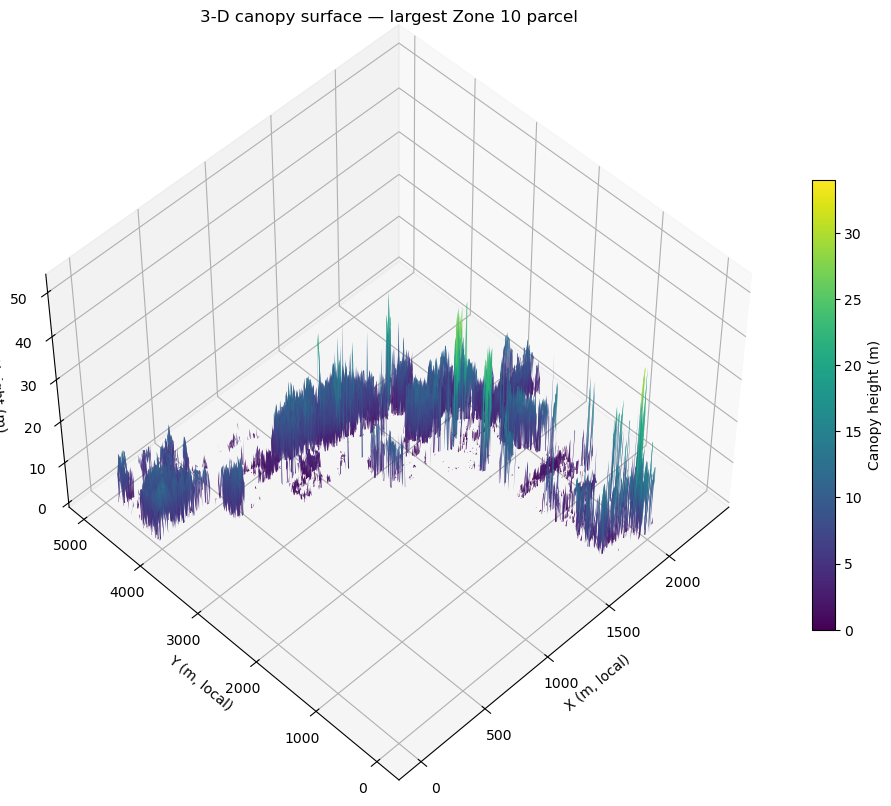

In [28]:
# 3-D canopy surface for the largest Zone 10 parcel
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # registers 3D projection
import rasterio as rio

# ---- Load height array + transform (prefer saved clip)
Z = None
T = None
nodata = None

if 'clipped_tif_path' in globals():
    from pathlib import Path
    if Path(clipped_tif_path).exists():
        with rio.open(clipped_tif_path) as src:
            Z = src.read(1)
            T = src.transform
            nodata = src.nodata

# Fallback to in-memory arrays from earlier cells
if Z is None and 'hgt' in globals() and 'clipped_transform' in globals():
    Z = hgt.copy()
    T = clipped_transform
    nodata = None

assert Z is not None and T is not None, "No clipped raster available. Run the clip/save cell first."

# ---- Mask invalid/negative heights
mask = ~np.isfinite(Z)
if nodata is not None:
    mask |= (Z == nodata)
mask |= (Z < 0)
Z = ma.masked_array(Z, mask=mask)

# ---- Build X/Y in map units (meters) from affine transform
rows, cols = Z.shape
j = np.arange(cols) + 0.5  # pixel centers
i = np.arange(rows) + 0.5
J, I = np.meshgrid(j, i)
X = T.a * J + T.b * I + T.c
Y = T.d * J + T.e * I + T.f

# ---- Downsample for speed (target <= ~400k points)
max_points = 400_000
step = int(np.ceil(np.sqrt((rows * cols) / max_points)))
step = max(step, 1)
X_d = X[::step, ::step]
Y_d = Y[::step, ::step]
Z_d = Z[::step, ::step]

# Recenter XY so axes are small numbers (nicer to view)
X0 = X_d.min()
Y0 = Y_d.min()
Xr = X_d - X0
Yr = Y_d - Y0

# ---- Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(
    Xr, Yr, Z_d,
    rstride=1, cstride=1, linewidth=0, antialiased=True,
    cmap="viridis"
)

fig.colorbar(surf, ax=ax, shrink=0.6, pad=0.05, label="Canopy height (m)")
ax.set_xlabel("X (m, local)")
ax.set_ylabel("Y (m, local)")
ax.set_zlabel("Height (m)")
ax.set_title("3-D canopy surface — largest Zone 10 parcel")

# A nicer initial camera angle
ax.view_init(elev=50, azim=-135)

# Optional: vertical exaggeration (e.g., 1.5). Set to 1.0 for true scale.
z_exag = 1.5
z_min, z_max = np.nanmin(Z_d), np.nanmax(Z_d)
ax.set_zlim(z_min, z_min + (z_max - z_min) * z_exag)

plt.tight_layout()


In [44]:
# ALL-1 — setup & paths
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.features import rasterize
from rasterio.mask import mask
from shapely.geometry import box
from pyproj import CRS

# EDIT these for your machine
parcels_shp = Path(r"C:\Users\jbros\OneDrive\Documents\SanDiego_RemoteSensing\Agricultural_Commodity_2020_shapefile\Agricultural_Commodity_2020.shp")
zone10_tif  = Path(r"E:\NAIP\nDSM_Veg2014_02-011.tif")

# Height bins: 0–2, 2–4, ..., 18–20 m  (last edge inclusive)
bin_edges = np.arange(0, 22, 2)   # [0,2,4,...,20]
bin_labels = [f"{bin_edges[i]}–{bin_edges[i+1]} m" for i in range(len(bin_edges)-1)]

assert parcels_shp.exists(), f"Parcels not found: {parcels_shp}"
assert zone10_tif.exists(), f"Raster not found: {zone10_tif}"


In [46]:
# ALL-2 — read raster + parcels; keep only parcels intersecting Zone 10 footprint
with rio.open(zone10_tif) as zds:
    z_crs = CRS.from_user_input(zds.crs)
    z_transform = zds.transform
    z_shape = (zds.height, zds.width)
    z_bounds_poly = box(*zds.bounds)
    # read first band (height); if there are multiple, adjust as needed
    Z = zds.read(1).astype("float32")
    z_nodata = zds.nodata

# load parcels and reproject to raster CRS
parcels = gpd.read_file(parcels_shp)
if parcels.crs is None:
    raise ValueError("Parcels shapefile has no CRS; set it before proceeding.")
parcels = parcels.to_crs(z_crs.to_string())

# keep parcels that touch the raster extent
parcels = parcels[parcels.geometry.intersects(z_bounds_poly)].copy()
parcels["geometry"] = parcels.geometry.buffer(0)  # fix minor invalids

# choose an ID column; fallback to index if 'site_id' missing
id_col = "site_id" if "site_id" in parcels.columns else None
if id_col is None:
    parcels["site_id"] = parcels.index.astype(str)
    id_col = "site_id"

# dense integer codes for rasterizing (1..N), 0 = background
parcels = parcels.reset_index(drop=True)
parcels["code"] = np.arange(1, len(parcels) + 1, dtype=np.int32)

# subset of attributes to carry through
attr_cols = [c for c in ["site_id", "permit_num", "site_name", "commodity"] if c in parcels.columns]
attrs = parcels[["code"] + attr_cols].copy()

print(f"Parcels intersecting Zone 10 extent: {len(parcels)}")


Parcels intersecting Zone 10 extent: 671


In [48]:
# ALL-3 — rasterize parcel codes onto the Zone 10 grid
shapes = [(geom, int(code)) for geom, code in zip(parcels.geometry, parcels["code"])]
parcel_grid = rasterize(
    shapes=shapes,
    out_shape=z_shape,
    transform=z_transform,
    fill=0,
    dtype="int32",
    all_touched=False  # set True to be more inclusive around edges
)

# quick sanity
print("parcel_grid unique sample:", np.unique(parcel_grid[:1000, :1000])[:10])


parcel_grid unique sample: [0]


In [50]:
# ALL-4 — compute per-parcel canopy coverage by height bins
# valid DSM pixels (>=0, not nodata, finite)
valid = np.isfinite(Z)
if z_nodata is not None:
    valid &= (Z != z_nodata)
valid &= (Z >= 0)

# bin indices (0..n_bins-1); include value == last edge in the last bin
n_bins = len(bin_edges) - 1
bin_idx = np.digitize(Z, bin_edges, right=False) - 1
# mark > max as invalid, keep == last edge in last bin
too_high = Z > bin_edges[-1]
bin_idx[too_high] = -1
eq_last = Z == bin_edges[-1]
bin_idx[eq_last] = n_bins - 1

# keep only pixels inside a parcel AND valid height AND in-range bin
inside = parcel_grid > 0
mask = inside & valid & (bin_idx >= 0)

codes_v = parcel_grid[mask]
bins_v  = bin_idx[mask]

# combine (code, bin) into one index and count via bincount
max_code = int(parcels["code"].max())
combined = codes_v.astype(np.int64) * n_bins + bins_v.astype(np.int64)
counts = np.bincount(combined, minlength=(max_code + 1) * n_bins)
counts = counts.reshape((max_code + 1, n_bins))  # row 0 is background

# pixel area (m²)
px_area = abs(z_transform.a) * abs(z_transform.e)

# area per (parcel_code, bin)
area_m2 = counts[1:, :] * px_area  # drop background row

# parcel intersection area within raster grid (all pixels, not just vegetated)
parcel_px_counts = np.bincount(parcel_grid.ravel(), minlength=max_code + 1)[1:]
parcel_area_m2 = parcel_px_counts * px_area

# vegetated area per parcel (sum over bins)
veg_area_m2 = area_m2.sum(axis=1)

# build long-form table
rows = []
for i, code in enumerate(parcels["code"].values, start=0):
    for b in range(n_bins):
        rows.append({
            "code": code,
            "height_bin": bin_labels[b],
            "pixel_count": int(counts[code, b]),  # use counts with background row included
            "area_m2": area_m2[i, b],
        })
long_df = pd.DataFrame(rows)

# add attrs + percents
per_parcel = pd.DataFrame({
    "code": parcels["code"].values,
    "parcel_area_m2": parcel_area_m2,
    "veg_area_m2": veg_area_m2
})
out_df = long_df.merge(attrs, on="code", how="left").merge(per_parcel, on="code", how="left")
out_df["pct_of_parcel_%"] = np.where(out_df["parcel_area_m2"] > 0, out_df["area_m2"] / out_df["parcel_area_m2"] * 100.0, 0.0)
out_df["pct_of_veg_%"]    = np.where(out_df["veg_area_m2"]    > 0, out_df["area_m2"] / out_df["veg_area_m2"]    * 100.0, 0.0)

# tidy columns & sort
order_cols = attr_cols + ["code", "height_bin", "pixel_count", "area_m2", "pct_of_parcel_%", "pct_of_veg_%", "veg_area_m2", "parcel_area_m2"]
order_cols = [c for c in order_cols if c in out_df.columns]
out_df = out_df[order_cols].sort_values(order_cols[:1] + ["code", "height_bin"]).reset_index(drop=True)

print("rows:", len(out_df), "| parcels:", out_df["code"].nunique())
out_df.head(10)


rows: 6710 | parcels: 671


,site_id,permit_num,site_name,commodity,code,height_bin,pixel_count,area_m2,pct_of_parcel_%,pct_of_veg_%,veg_area_m2,parcel_area_m2
0,1,37N1001,PAUMA VALLEY COUNTRY CLUB,RECREATION AREA,15,0–2 m,380643,380643.0,69.308505,82.324685,462368.0,549201.0
1,1,37N1001,PAUMA VALLEY COUNTRY CLUB,RECREATION AREA,15,10–12 m,12267,12267.0,2.233608,2.653082,462368.0,549201.0
2,1,37N1001,PAUMA VALLEY COUNTRY CLUB,RECREATION AREA,15,12–14 m,11786,11786.0,2.146027,2.549052,462368.0,549201.0
3,1,37N1001,PAUMA VALLEY COUNTRY CLUB,RECREATION AREA,15,14–16 m,9487,9487.0,1.727419,2.051829,462368.0,549201.0
4,1,37N1001,PAUMA VALLEY COUNTRY CLUB,RECREATION AREA,15,16–18 m,7504,7504.0,1.366349,1.622950,462368.0,549201.0
5,1,37N1001,PAUMA VALLEY COUNTRY CLUB,RECREATION AREA,15,18–20 m,5141,5141.0,0.936087,1.111885,462368.0,549201.0
6,1,37N1001,PAUMA VALLEY COUNTRY CLUB,RECREATION AREA,15,2–4 m,4556,4556.0,0.829569,0.985362,462368.0,549201.0
7,1,37N1001,PAUMA VALLEY COUNTRY CLUB,RECREATION AREA,15,4–6 m,8175,8175.0,1.488526,1.768072,462368.0,549201.0
8,1,37N1001,PAUMA VALLEY COUNTRY CLUB,RECREATION AREA,15,6–8 m,10759,10759.0,1.959028,2.326934,462368.0,549201.0
9,1,37N1001,PAUMA VALLEY COUNTRY CLUB,RECREATION AREA,15,8–10 m,12050,12050.0,2.194097,2.606149,462368.0,549201.0


In [96]:
# ALL-5 (simple fix) — reorder WIDE columns to 0–20 m left-to-right (no heavy ops)

import re

# 1) Identify ID cols that should stay on the left (keep only those that exist)
id_cols = [c for c in ["site_id","permit_num","site_name","commodity","code"] if c in wide_df.columns]

# 2) Current bin columns (everything else)
bin_cols = [c for c in wide_df.columns if c not in id_cols]

# 3) Preferred order if you have bin_edges; else fall back to numeric sort on the left edge
ordered_bins = []
if 'bin_edges' in globals():
    ordered_bins = [f"{bin_edges[i]}–{bin_edges[i+1]} m" for i in range(len(bin_edges)-1)]
    bin_cols_sorted = [b for b in ordered_bins if b in bin_cols]
    # include any leftover bins (if labels differ slightly), sorted by numeric left edge
    leftovers = [b for b in bin_cols if b not in bin_cols_sorted]
else:
    bin_cols_sorted = []
    leftovers = bin_cols

def left_edge_val(label: str):
    m = re.match(r'^\s*(\d+(?:\.\d+)?)\s*[–-]', str(label))  # handles en-dash or hyphen
    return float(m.group(1)) if m else float('inf')

bin_cols_sorted += sorted(leftovers, key=left_edge_val)

# 4) Reorder DataFrame columns
wide_df = wide_df[id_cols + bin_cols_sorted]

# 5) Preview
display(wide_df.head(10))

# (optional) recompute ≥2 m total using the sorted bins (skip the first 0–2 bin if present)
mask_bins = [b for b in bin_cols_sorted if not str(b).startswith("0–2")]
wide_df["pct_ge_2m"] = wide_df[mask_bins].sum(axis=1)
display(wide_df.sort_values("pct_ge_2m", ascending=False).head(10))


height_bin,site_id,permit_num,site_name,commodity,code,0–2 m,2–4 m,4–6 m,6–8 m,8–10 m,10–12 m,12–14 m,14–16 m,16–18 m,18–20 m,pct_ge_2m
0,1,37N1001,PAUMA VALLEY COUNTRY CLUB,RECREATION AREA,15,69.308505,0.829569,1.488526,1.959028,2.194097,2.233608,2.146027,1.727419,1.366349,0.936087,14.880709
1,ACA003,37P3028,LOS NINOS,N-OUTDR GRWN CUT FLWRS OR GREENS,52,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,ACA003,37P3028,LOS NINOS,N-OUTDR GRWN CUT FLWRS OR GREENS,662,45.997777,8.421345,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.421345
3,ACB001,37P0073,N. OF SAN LUIS REY RIVER,KUMQUAT,189,7.939541,0.637016,0.434329,0.364837,0.602270,0.718091,0.388001,0.567524,0.550151,0.521195,4.783414
4,ACB001,37P0106,PALA GATEWAY,"CITRUS, GRAPEFRUIT, ORANGE, AVOCADO",139,8.859418,4.857762,4.982281,3.739223,2.564056,1.001632,0.418311,0.322105,0.182973,0.112950,18.181292
5,ACB002,37P0073,S. OF SAN LUIS REY RIVER,"ORANGE, TANGERINE, APPLE, PEAR, QUINCE, NECTAR...",190,23.506407,11.724767,8.691592,5.591013,3.572407,1.770757,0.532210,0.219765,0.153765,0.072319,32.328594
6,ACB504,37P3028,WOLLAM- RANCHO TUCKAHOE I,AVOCADO,51,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,ACB504,37P3028,WOLLAM- RANCHO TUCKAHOE I,AVOCADO,661,22.550906,8.460506,12.781383,14.779593,12.888789,6.043858,1.449989,0.172298,0.000000,0.000000,56.576415
8,ACD001,37P4559,PALA ROCA,"GRAPE, WINE",400,8.118219,1.795735,3.329592,4.002993,7.295174,6.958474,3.404415,3.067714,0.598578,0.000000,30.452675
9,ACD005,37P3405,"5328 HWY 76, FALLBROOK","GRAPEFRUIT, LEMON, ORANGE, AVOCADO, UNCUL NON-AG",347,14.578535,11.658474,11.562235,4.457264,4.811797,3.831247,1.798358,0.448159,0.103890,0.066564,38.737989


height_bin,site_id,permit_num,site_name,commodity,code,0–2 m,2–4 m,4–6 m,6–8 m,8–10 m,10–12 m,12–14 m,14–16 m,16–18 m,18–20 m,pct_ge_2m
22,ACE058,37P9886,"7969 AVIENDA MIL FLORES, BONSALL",AVOCADO,589,4.807538,2.012756,4.717798,10.897087,24.066536,29.204192,14.332874,4.480626,0.624980,0.019230,180.712157
438,CFE088,37P7973,"31070 MESA CREST, VALLEY CENTER",AVOCADO,488,8.968872,6.652918,10.719066,15.838911,19.565759,19.196887,11.636576,2.806226,0.374319,0.165759,173.912840
479,CFE279,37P1007,KAY - ORGANIC,AVOCADO,263,7.628810,2.158926,7.302250,17.180697,32.792090,22.197025,3.918723,0.154209,0.000000,0.000000,171.407837
235,BNX001,37P9248,"LOCATED ON JEREMY RD JUST SOUTH OF ARUBA RD, PALA",AVOCADO,559,7.267960,6.123582,12.745731,16.744595,22.811346,18.649738,6.685438,1.061714,0.098163,0.028416,169.897445
641,CHE034,37P9450,"HOLLYHILL RD APN 17202123, VISTA","LEMON, AVOCADO",568,9.107378,6.413043,13.491436,21.640316,21.320817,14.423584,4.051383,0.316206,0.000000,0.000000,163.313570
523,CFI004,37P0655,"32845 VIA DEL VENADO, VALLEY CENTER",AVOCADO,246,12.937843,7.908131,16.172304,23.997693,21.896547,9.876388,1.431688,0.173006,0.122859,0.020059,163.197352
450,CFE137,37P4268,"12500 MESA VERDE, VALLEY CENTER (CURT",ORANGE,371,7.925648,17.316542,57.685477,5.602648,0.187697,0.139259,0.014128,0.000000,0.000000,0.000000,161.891499
266,BPD011,3314520,NICOL,AVOCADO,160,9.674408,7.347082,11.718320,15.349349,17.633329,15.526066,9.421003,2.454029,0.845239,0.590167,161.769168
483,CFE289,37P8620,PAUMA ALTO RANCH,AVOCADO,518,10.134608,2.754863,7.533025,17.278858,23.063096,18.311410,8.398361,2.426007,0.596399,0.061312,160.846664
595,CFX007,37P1007,GOLDEN PARK RANCH LLC,AVOCADO,271,11.194944,4.568344,9.087970,15.976270,21.767323,19.040803,8.413238,1.358518,0.097868,0.070276,160.761218


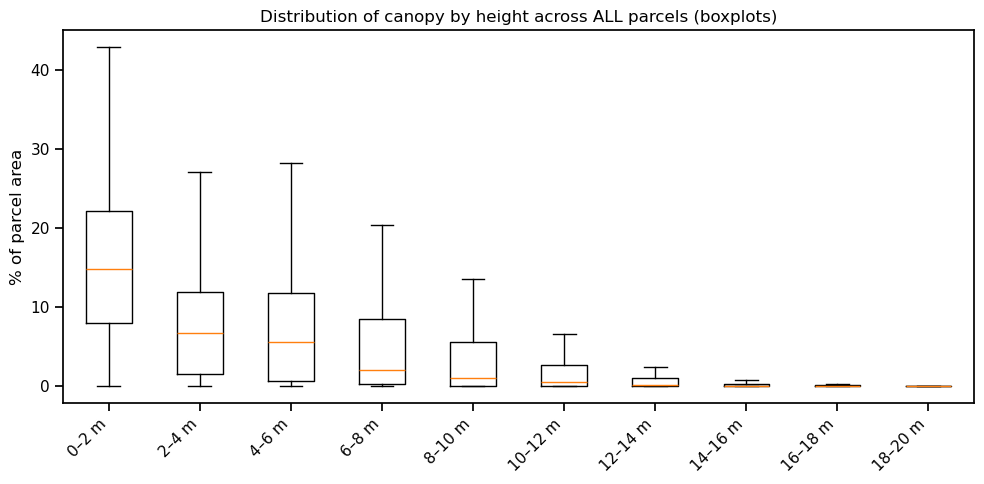

In [100]:
# ALL-6A — distribution across ALL parcels by HEIGHT BIN (boxplots 0–20 order)

import numpy as np, pandas as pd, matplotlib.pyplot as plt

# Ensure height-bin order (0–2, 2–4, ..., 18–20)
if 'bin_labels' not in globals():
    assert 'bin_edges' in globals(), "Need bin_edges or bin_labels defined."
    bin_labels = [f"{bin_edges[i]}–{bin_edges[i+1]} m" for i in range(len(bin_edges)-1)]
ordered_bins = bin_labels[:]

# Long table -> lists of values per bin
df = out_df[out_df["height_bin"].isin(ordered_bins)].copy()
df["height_bin"] = pd.Categorical(df["height_bin"], categories=ordered_bins, ordered=True)
df = df.sort_values("height_bin")

data = [df.loc[df["height_bin"] == b, "pct_of_parcel_%"].to_numpy() for b in ordered_bins]

plt.figure(figsize=(10, 5))
plt.boxplot(data, positions=np.arange(1, len(ordered_bins)+1), showfliers=False)
plt.xticks(np.arange(1, len(ordered_bins)+1), ordered_bins, rotation=45, ha="right")
plt.ylabel("% of parcel area")
plt.title("Distribution of canopy by height across ALL parcels (boxplots)")
plt.tight_layout()


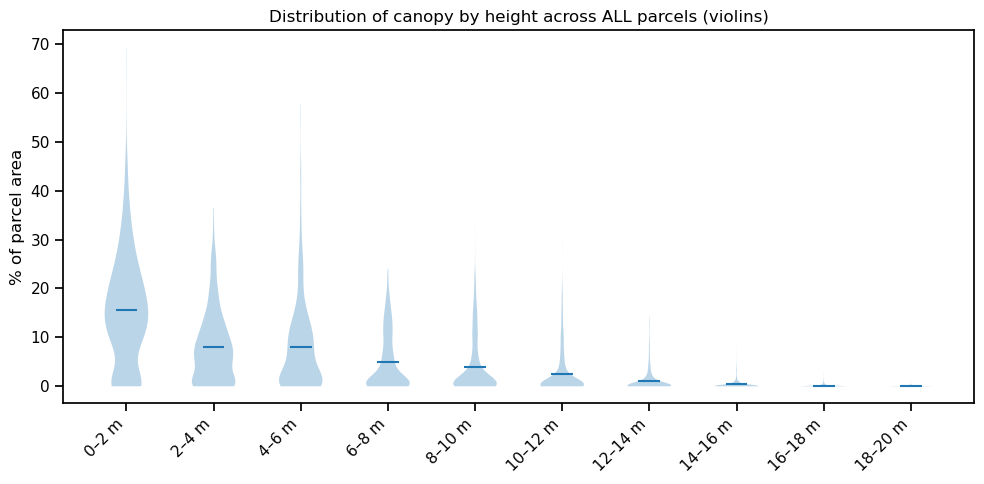

In [102]:
# ALL-6B — same, as violin plots (still 0–20 order)

import numpy as np, matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.violinplot(data, showmeans=True, showextrema=False, showmedians=False)
plt.xticks(np.arange(1, len(ordered_bins)+1), ordered_bins, rotation=45, ha="right")
plt.ylabel("% of parcel area")
plt.title("Distribution of canopy by height across ALL parcels (violins)")
plt.tight_layout()


In [106]:
# KM-0 — lightweight prep (enforce bin order + trim columns) and memory check
import pandas as pd, numpy as np, gc

assert 'out_df' in globals(), "Run the ALL-parcels cells to create out_df first."

# Canonical 0–2,2–4,...,18–20 labels
if 'bin_labels' not in globals():
    assert 'bin_edges' in globals(), "Need bin_edges or bin_labels defined."
    bin_labels = [f"{bin_edges[i]}–{bin_edges[i+1]} m" for i in range(len(bin_edges)-1)]

keep_cols = ['code','height_bin','pct_of_parcel_%','pct_of_veg_%'] + [c for c in ['site_id','site_name','commodity'] if c in out_df.columns]
odf = out_df.loc[out_df['height_bin'].isin(bin_labels), keep_cols].copy()
odf['height_bin'] = pd.Categorical(odf['height_bin'], categories=bin_labels, ordered=True)

print("rows:", len(odf), "| parcels:", odf['code'].nunique())
print(odf.memory_usage(deep=True).sum()/1e6, "MB")
gc.collect();


rows: 6710 | parcels: 671
1.518263 MB


In [108]:
# KM-1 — build feature matrix X (safe pivot; bins ordered 0–20; float32)
# Choose metric to cluster on:
METRIC = "pct_of_parcel_%"   # or "pct_of_veg_%"

id_cols = [c for c in ['site_id','site_name','commodity'] if c in odf.columns] + ['code']

comp_df = (
    odf.pivot_table(
        index=id_cols,
        columns='height_bin',
        values=METRIC,
        aggfunc='sum',
        fill_value=0.0,
        observed=True,   # avoids creating unused category combinations
        sort=False       # keep categorical bin order
    )
    .reset_index()
)

# Ensure all bins exist as columns and in the right order
for b in bin_labels:
    if b not in comp_df.columns:
        comp_df[b] = 0.0
comp_cols = bin_labels[:]  # 0–20 order
comp_df = comp_df[id_cols + comp_cols]

# Feature matrix (float32 saves RAM)
X = comp_df[comp_cols].to_numpy(dtype=np.float32)

print("X shape:", X.shape, "| dtype:", X.dtype)


X shape: (669, 10) | dtype: float32


In [110]:
# KM-2 — pick K using MiniBatchKMeans (RAM-friendly) + silhouette on a small sample
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import numpy as np

Ks = list(range(2, 9))
sils = []
idx_samp = np.random.choice(X.shape[0], size=min(2000, X.shape[0]), replace=False)

for k in Ks:
    km = MiniBatchKMeans(n_clusters=k, n_init=20, batch_size=2048, random_state=0)
    labels = km.fit_predict(X)
    sils.append(silhouette_score(X[idx_samp], labels[idx_samp]) if X.shape[0] > 10 else np.nan)

best_k = Ks[int(np.nanargmax(sils))] if np.isfinite(sils).any() else 4
print("silhouettes:", dict(zip(Ks, [None if not np.isfinite(s) else round(float(s),3) for s in sils])))
print("Chosen K:", best_k)


C:\Users\jbros\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2560 or by setting the environment variable OMP_NUM_THREADS=3
  warnings.warn(
C:\Users\jbros\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2560 or by setting the environment variable OMP_NUM_THREADS=3
  warnings.warn(
C:\Users\jbros\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2560 or by setting the environment variable OMP_NUM_THREADS=3
  warnings.warn(
C:\User

silhouettes: {2: 0.343, 3: 0.365, 4: 0.434, 5: 0.406, 6: 0.392, 7: 0.377, 8: 0.367}
Chosen K: 4


C:\Users\jbros\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2560 or by setting the environment variable OMP_NUM_THREADS=3
  warnings.warn(


In [112]:
# KM-3 — fit final K-means (MiniBatch) and attach labels
from sklearn.cluster import MiniBatchKMeans

K_FINAL = best_k  # set manually if you prefer (e.g., 4 or 5)
km = MiniBatchKMeans(n_clusters=K_FINAL, n_init=50, batch_size=4096, random_state=0)
comp_df['cluster_km'] = km.fit_predict(X)

print(comp_df['cluster_km'].value_counts().sort_index())
comp_df.head(3)


C:\Users\jbros\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2560 or by setting the environment variable OMP_NUM_THREADS=3
  warnings.warn(


cluster_km
0    142
1    204
2    214
3    109
Name: count, dtype: int64


height_bin,site_id,site_name,commodity,code,0–2 m,2–4 m,4–6 m,6–8 m,8–10 m,10–12 m,12–14 m,14–16 m,16–18 m,18–20 m,cluster_km
0,1,PAUMA VALLEY COUNTRY CLUB,RECREATION AREA,15,69.308505,0.829569,1.488526,1.959028,2.194097,2.233608,2.146027,1.727419,1.366349,0.936087,2
1,ACA003,LOS NINOS,N-OUTDR GRWN CUT FLWRS OR GREENS,52,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2,ACA003,LOS NINOS,N-OUTDR GRWN CUT FLWRS OR GREENS,662,45.997777,8.421345,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2


C:\Users\jbros\AppData\Local\Temp\ipykernel_23432\1667989304.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(comp_cols, rotation=45, ha='right')


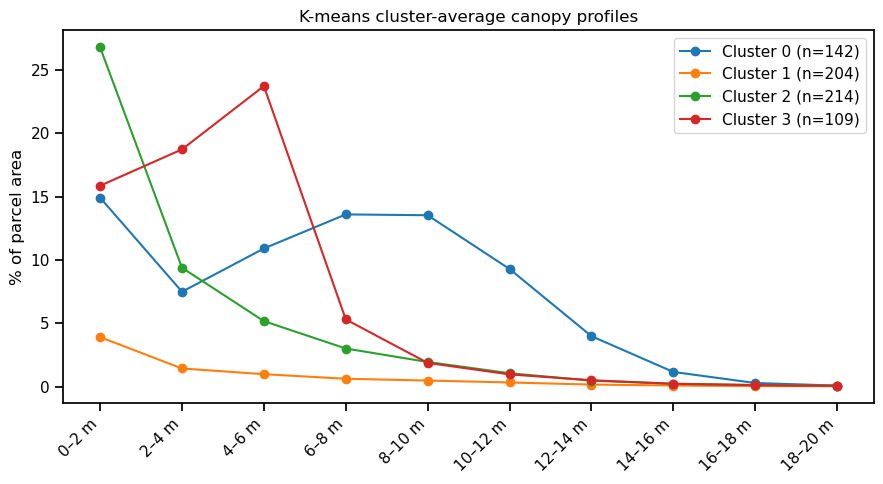

In [114]:
# KM-4 — cluster-average profiles (height bins in 0–20 order)
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(9,5))
for k in sorted(comp_df['cluster_km'].unique()):
    prof = comp_df.loc[comp_df['cluster_km']==k, comp_cols].to_numpy(np.float32).mean(axis=0)
    ax.plot(comp_cols, prof, marker='o', label=f"Cluster {k} (n={(comp_df['cluster_km']==k).sum()})")

ax.set_ylabel("% of parcel area" if METRIC=="pct_of_parcel_%" else "% of vegetated area")
ax.set_title("K-means cluster-average canopy profiles")
ax.set_xticklabels(comp_cols, rotation=45, ha='right')
ax.legend()
plt.tight_layout()


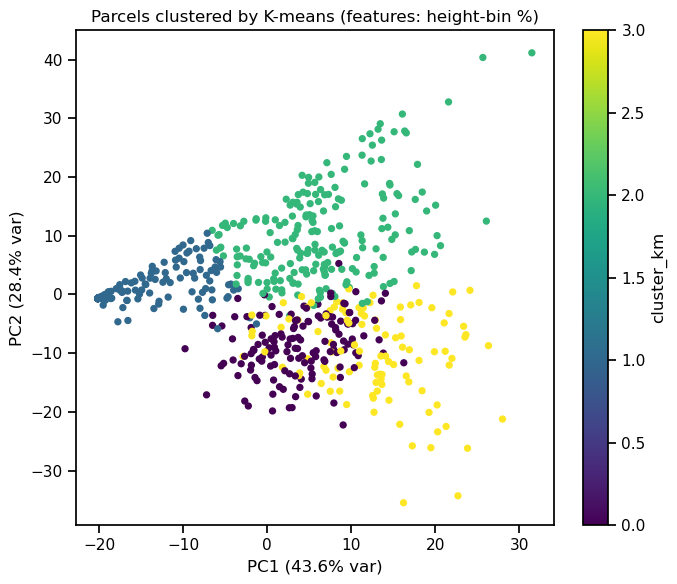

In [116]:
# KM-5 — 2D PCA scatter colored by K-means cluster (float32 to save RAM)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(n_components=2, random_state=0)
Z2 = pca.fit_transform(X.astype(np.float32, copy=False))

plt.figure(figsize=(7,6))
sc = plt.scatter(Z2[:,0], Z2[:,1], c=comp_df['cluster_km'], s=18)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("Parcels clustered by K-means (features: height-bin %)")
plt.colorbar(sc, label="cluster_km")
plt.tight_layout()


C:\Users\jbros\AppData\Local\Temp\ipykernel_23432\852799161.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis", len(comp_cols))


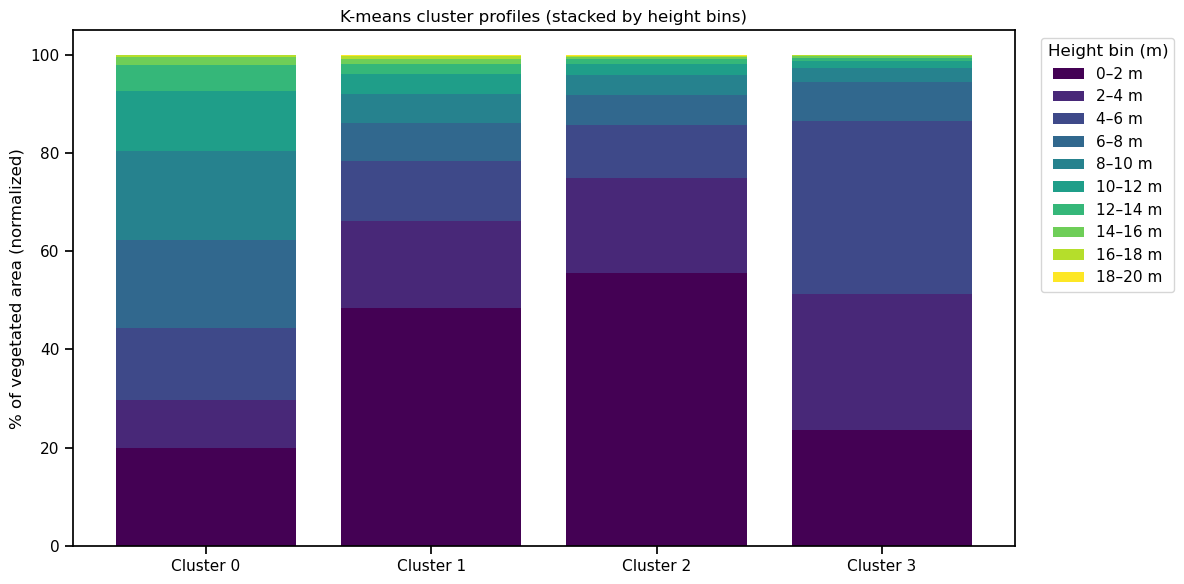

In [122]:
# KM-7 (revised) — Stacked bar of K-means cluster profiles with VIRIDIS colors
# Requires: comp_df with 'cluster_km', comp_cols (0–20 bins in order)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

assert 'comp_df' in globals() and 'cluster_km' in comp_df.columns
assert 'comp_cols' in globals() and len(comp_cols) > 0

# Average profile per cluster
profiles = (comp_df
            .groupby('cluster_km')[comp_cols]
            .mean()
            .sort_index())

# Normalize each cluster to sum to 100 for easy comparison (toggle if desired)
NORMALIZE_TO_100 = True
if NORMALIZE_TO_100:
    rs = profiles.sum(axis=1).replace(0, np.nan)
    profiles = profiles.div(rs, axis=0).fillna(0) * 100.0

clusters = profiles.index.to_list()
x = np.arange(len(clusters))

# VIRIDIS colors for each height bin (kept consistent left→right)
cmap = plt.cm.get_cmap("viridis", len(comp_cols))
colors = [cmap(i) for i in range(len(comp_cols))]

plt.figure(figsize=(12, 6))
bottom = np.zeros(len(clusters), dtype=float)
for j, col in enumerate(comp_cols):  # already ordered 0–20
    vals = profiles[col].to_numpy()
    plt.bar(x, vals, bottom=bottom, label=col, color=colors[j], edgecolor='none')
    bottom += vals

plt.xticks(x, [f"Cluster {c}" for c in clusters])
plt.ylabel("% of vegetated area (normalized)" if NORMALIZE_TO_100 else "% metric average")
plt.title("K-means cluster profiles (stacked by height bins)")
plt.legend(title="Height bin (m)", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()


In [138]:
# LST-1 — paths, deps, and bin/order context
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.mask import mask
from shapely.geometry import box

# EDIT if needed
lst_path = Path(r"C:\Users\jbros\Downloads\LC08_L2SP_040037_20140829_20200911_02_T1_ST_B10.TIF")
parcels_shp = Path(r"C:\Users\jbros\OneDrive\Documents\SanDiego_RemoteSensing\Agricultural_Commodity_2020_shapefile\Agricultural_Commodity_2020.shp")

assert lst_path.exists(), f"Missing LST raster: {lst_path}"
assert parcels_shp.exists(), f"Missing parcels shapefile: {parcels_shp}"
assert 'comp_df' in globals() and 'cluster_km' in comp_df.columns, "Run KM-1..KM-3 (k-means) first."

# canonical height-bin order (0–2,2–4,...,18–20)
if 'bin_labels' not in globals():
    assert 'bin_edges' in globals(), "Need bin_edges or bin_labels defined."
    bin_labels = [f"{bin_edges[i]}–{bin_edges[i+1]} m" for i in range(len(bin_edges)-1)]


In [140]:
# LST-2 — per-parcel LST stats (mean/median/etc.), aligned to K-means parcels
# joins by 'site_id' (preferred). If your comp_df lacks 'site_id', switch to 'code' and add that to the parcels first.

join_key = 'site_id'
assert join_key in comp_df.columns, f"'{join_key}' not in comp_df; add it or change join_key."
parcels = gpd.read_file(parcels_shp)
assert join_key in parcels.columns, f"'{join_key}' not in parcels shapefile."

# keep only parcels present in the clustering table
keep_ids = set(comp_df[join_key].astype(str))
parcels = parcels[parcels[join_key].astype(str).isin(keep_ids)].copy()

# reproject to LST CRS and intersect with LST footprint
with rio.open(lst_path) as src:
    lst_crs = src.crs
    lst_bounds = box(*src.bounds)
    nodata = src.nodata
    # try to read scale params from tags; fallback to Landsat C2 defaults
    t_all = {**src.tags(), **src.tags(1)}
    sf = None; off = None
    for k,v in t_all.items():
        ku = k.upper()
        if 'SCALE' in ku and 'ST' in ku and v.replace('.','',1).replace('-','',1).isdigit():
            sf = float(v)
        if 'OFFSET' in ku and 'ADD' in ku and v.replace('.','',1).replace('-','',1).isdigit():
            off = float(v)
    if sf is None:  sf = 0.00341802
    if off is None: off = 149.0

parcels = parcels.to_crs(lst_crs)
parcels = parcels[parcels.geometry.intersects(lst_bounds)].copy()
parcels['geometry'] = parcels.buffer(0)

# iterate parcels; clip window; compute robust stats
rows = []
with rio.open(lst_path) as src:
    for idx, row in parcels.iterrows():
        geom = row.geometry
        try:
            arr, tr = mask(src, [geom.__geo_interface__], crop=True, filled=True, nodata=nodata)
            band = arr[0].astype('float32')
        except Exception:
            continue
        valid = np.isfinite(band)
        if nodata is not None:
            valid &= (band != nodata)
        if not np.any(valid):
            continue
        # Convert to Celsius
        tempC = (band * sf + off) - 273.15
        vals = tempC[valid]
        rows.append({
            join_key: str(row[join_key]),
            "lstC_mean": float(np.nanmean(vals)),
            "lstC_median": float(np.nanmedian(vals)),
            "lstC_p10": float(np.nanpercentile(vals, 10)),
            "lstC_p90": float(np.nanpercentile(vals, 90)),
            "n_valid": int(valid.sum())
        })

lst_df = pd.DataFrame(rows)
lst_df.head(3)


,site_id,lstC_mean,lstC_median,lstC_p10,lstC_p90,n_valid
0,AWC001,39.724438,39.361237,37.600299,42.291180,805
1,AWC002,41.905098,41.712860,40.666931,43.423895,53
2,AWH100,40.342281,40.164459,38.823248,42.019110,307


In [142]:
# LST-3 — join LST stats to K-means labels and summarize by cluster
assert not lst_df.empty, "No LST stats computed; check geometry overlap and paths."

# attach cluster labels
key_cols = [c for c in [join_key, 'cluster_km'] if c in comp_df.columns]
lab_df = comp_df[key_cols].drop_duplicates(subset=[join_key])
joined = lst_df.merge(lab_df, on=join_key, how='inner')

# cluster summaries
clu_stats = (joined
             .groupby('cluster_km')[['lstC_mean','lstC_median','lstC_p10','lstC_p90']]
             .agg(['mean','median'])
             .round(2))

display(joined.head(10))
display(clu_stats)


,site_id,lstC_mean,lstC_median,lstC_p10,lstC_p90,n_valid,cluster_km
0,AWC001,39.724438,39.361237,37.600299,42.291180,805,1
1,AWC002,41.905098,41.712860,40.666931,43.423895,53,1
2,AWH100,40.342281,40.164459,38.823248,42.019110,307,1
3,AWW023,45.589916,45.640167,44.570996,46.586261,43,1
4,AWY277,45.338837,45.537628,41.563153,48.885559,544,1
5,AWY291,44.884632,45.064209,43.512079,45.927618,98,1
6,CFE122,43.596706,43.618378,42.073456,45.353369,70,2
7,CFH056,47.214020,47.318390,43.665887,50.555267,307,2
8,CFD011,47.943481,47.889191,46.375714,49.648822,75,2
9,CFD028,39.070591,38.653717,36.438159,42.523260,490,0


lstC_mean        lstC_median        lstC_p10        lstC_p90       
                mean median        mean median     mean median     mean median
cluster_km                                                                    
0              40.47  40.72       40.27  40.52    38.41  38.33    42.82  43.03
1              45.54  45.76       45.56  45.77    43.71  43.17    47.35  47.42
2              45.43  45.17       45.41  45.10    43.54  43.32    47.35  47.35
3              43.88  43.35       43.66  43.00    42.02  41.45    46.09  45.53

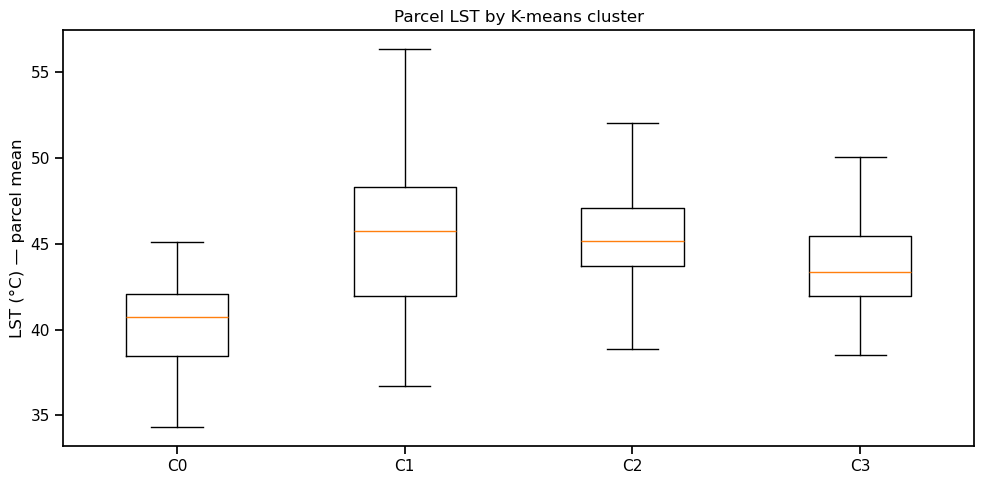

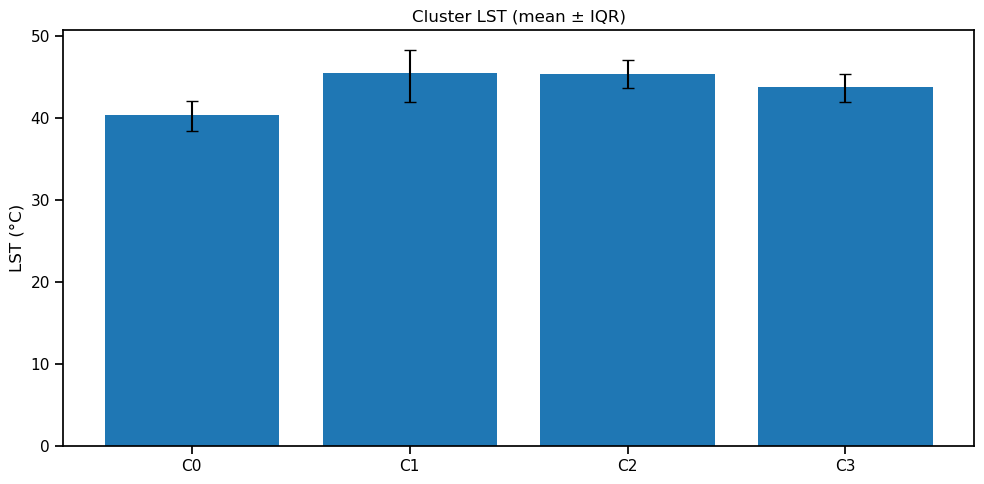

In [144]:
# LST-4 — visuals: boxplot of parcel LST by cluster + means with error bars
import matplotlib.pyplot as plt
import numpy as np

# Boxplot by cluster
plt.figure(figsize=(10,5))
clusters = sorted(joined['cluster_km'].unique())
data = [joined.loc[joined['cluster_km']==k, 'lstC_mean'].to_numpy() for k in clusters]
plt.boxplot(data, labels=[f"C{k}" for k in clusters], showfliers=False)
plt.ylabel("LST (°C) — parcel mean")
plt.title("Parcel LST by K-means cluster")
plt.tight_layout()

# Mean ± IQR bars per cluster
plt.figure(figsize=(10,5))
means = [np.mean(d) for d in data]
q25 = [np.percentile(d, 25) for d in data]
q75 = [np.percentile(d, 75) for d in data]
yerr = [np.array(means)-np.array(q25), np.array(q75)-np.array(means)]
x = np.arange(len(clusters))
plt.bar(x, means)
plt.errorbar(x, means, yerr=yerr, fmt='none', ecolor='black', capsize=4)
plt.xticks(x, [f"C{k}" for k in clusters])
plt.ylabel("LST (°C)")
plt.title("Cluster LST (mean ± IQR)")
plt.tight_layout()


C:\Users\jbros\AppData\Local\Temp\ipykernel_23432\2412800877.py:19: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  comp_wide = comp_long.pivot_table(index='site_id', columns='height_bin', values=METRIC_USED, aggfunc='sum', fill_value=0.0)


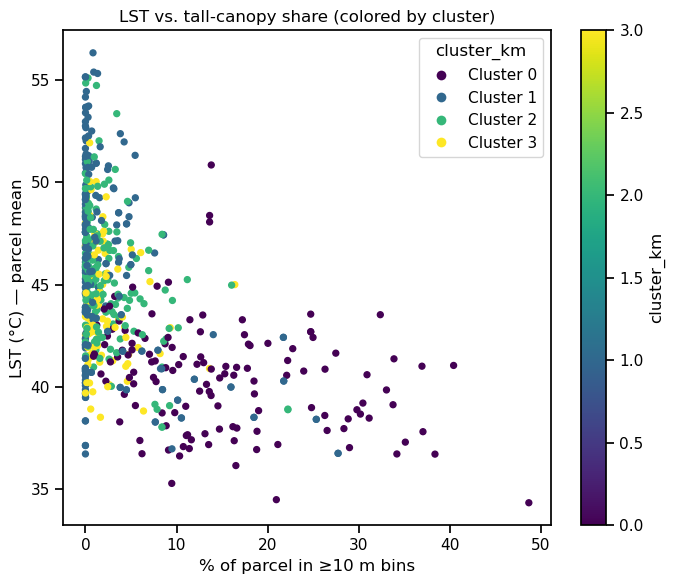

In [148]:
# LST-5 (revised) — add categorical legend for clusters (while keeping the colorbar)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

assert 'comp_cols' in globals(), "Need comp_cols (height-bin columns)."

# derive tall share from comp_df (≥10 m)
bin_mids = np.array([(float(b.split('–')[0]) + float(b.split('–')[1].split()[0]))/2.0 for b in comp_cols])
tall_mask = bin_mids >= 10.0

# choose metric consistent with KM-1 (change to pct_of_veg_% if that is what you used)
METRIC_USED = "pct_of_parcel_%"
comp_long = out_df[['code','height_bin',METRIC_USED,'site_id']].copy() if 'out_df' in globals() else None
assert comp_long is not None, "Need out_df for structural metric."
comp_long = comp_long[comp_long['height_bin'].isin(comp_cols)]
comp_wide = comp_long.pivot_table(index='site_id', columns='height_bin', values=METRIC_USED, aggfunc='sum', fill_value=0.0)
tall_share = comp_wide.iloc[:, np.where(tall_mask)[0]].sum(axis=1)

plot_tbl = joined.merge(tall_share.rename('tall_share_pct').reset_index(), on='site_id', how='left')

plt.figure(figsize=(7,6))
sc = plt.scatter(
    plot_tbl['tall_share_pct'],
    plot_tbl['lstC_mean'],
    c=plot_tbl['cluster_km'],
    s=18,
    cmap='viridis'  # keep consistent mapping for legend colors
)
plt.xlabel("% of parcel in ≥10 m bins")
plt.ylabel("LST (°C) — parcel mean")
plt.title("LST vs. tall-canopy share (colored by cluster)")

# colorbar
plt.colorbar(sc, label="cluster_km")

# categorical legend with one entry per cluster, using the SAME colormap/norm as the scatter
clusters = sorted([k for k in pd.unique(plot_tbl['cluster_km']) if pd.notna(k)])
handles = [
    Line2D(
        [0], [0],
        marker='o',
        linestyle='',
        markersize=7,
        markerfacecolor=sc.cmap(sc.norm(k)),
        markeredgecolor='none',
        label=f"Cluster {int(k)}"
    )
    for k in clusters
]
plt.legend(handles=handles, title="cluster_km", loc="best", frameon=True)

plt.tight_layout()


In [150]:
# NDVI-1 — setup & paths (Landsat 8/9 SR B4/B5), assumes K-means (comp_df with cluster_km) already done
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.mask import mask
from shapely.geometry import box

# EDIT paths if needed
red_path = Path(r"C:\Users\jbros\Downloads\LC08_L2SP_040037_20140829_20200911_02_T1_SR_B4.TIF")  # Red
nir_path = Path(r"C:\Users\jbros\Downloads\LC08_L2SP_040037_20140829_20200911_02_T1_SR_B5.TIF")  # NIR
parcels_shp = Path(r"C:\Users\jbros\OneDrive\Documents\SanDiego_RemoteSensing\Agricultural_Commodity_2020_shapefile\Agricultural_Commodity_2020.shp")

assert red_path.exists() and nir_path.exists(), "Missing B4/B5 paths."
assert parcels_shp.exists(), "Missing parcels shapefile."
assert 'comp_df' in globals() and 'cluster_km' in comp_df.columns, "Run KM-1..KM-3 first (to build comp_df with cluster_km)."

# we will join by site_id (preferred). Change to 'code' if needed.
join_key = 'site_id'
assert join_key in comp_df.columns, f"'{join_key}' not in comp_df; add it or change join_key."


In [152]:
# NDVI-2 — helpers to read scale/offset from tags (fallback to L2 SR defaults)
def read_scale_offset(tif_path, fallback_scale=2.75e-5, fallback_off=-0.2):
    with rio.open(tif_path) as src:
        tags = {**src.tags(), **src.tags(1)}
    scale = None
    offset = None
    for k, v in tags.items():
        ku = k.upper()
        try:
            fv = float(v)
        except Exception:
            continue
        if "SCALE" in ku:
            scale = fv
        if "OFFSET" in ku or "ADD" in ku:
            offset = fv
    return (scale if scale is not None else fallback_scale,
            offset if offset is not None else fallback_off)

red_sf, red_off = read_scale_offset(red_path)
nir_sf, nir_off = read_scale_offset(nir_path)
print("Red scale/offset:", red_sf, red_off, "| NIR scale/offset:", nir_sf, nir_off)


Red scale/offset: 2.75e-05 -0.2 | NIR scale/offset: 2.75e-05 -0.2


In [154]:
# NDVI-3 — per-parcel NDVI stats (mean/median/p10/p90), robust + memory-safe
parcels = gpd.read_file(parcels_shp)
assert join_key in parcels.columns, f"'{join_key}' not in parcels."

# keep only parcels present in clustering table
keep_ids = set(comp_df[join_key].astype(str))
parcels = parcels[parcels[join_key].astype(str).isin(keep_ids)].copy()

rows = []
with rio.open(red_path) as rs, rio.open(nir_path) as ns:
    r_crs, n_crs = rs.crs, ns.crs
    r_bounds, n_bounds = box(*rs.bounds), box(*ns.bounds)
    r_nodata, n_nodata = rs.nodata, ns.nodata

    # reproject parcels to each CRS separately, then intersect both footprints
    parcels_r = parcels.to_crs(r_crs)
    parcels_n = parcels.to_crs(n_crs)

    for i in range(len(parcels)):
        rid = str(parcels.iloc[i][join_key])
        geom_r = parcels_r.iloc[i].geometry
        geom_n = parcels_n.iloc[i].geometry

        # quick bbox overlap check
        if not geom_r.intersects(r_bounds) or not geom_n.intersects(n_bounds):
            continue

        try:
            r_arr, r_tr = mask(rs, [geom_r.__geo_interface__], crop=True, filled=True, nodata=r_nodata)
            n_arr, n_tr = mask(ns, [geom_n.__geo_interface__], crop=True, filled=True, nodata=n_nodata)
        except Exception:
            continue

        r = r_arr[0].astype("float32")
        n = n_arr[0].astype("float32")

        # align shapes if they differ by a 1px edge
        h = min(r.shape[0], n.shape[0])
        w = min(r.shape[1], n.shape[1])
        if h == 0 or w == 0:
            continue
        r = r[:h, :w]; n = n[:h, :w]

        # mask valid
        valid = np.isfinite(r) & np.isfinite(n)
        if r_nodata is not None: valid &= (r != r_nodata)
        if n_nodata is not None: valid &= (n != n_nodata)
        if not np.any(valid):
            continue

        # apply scale/offset to reflectance (surface reflectance)
        r_refl = r * red_sf + red_off
        n_refl = n * nir_sf + nir_off

        # NDVI = (NIR - Red)/(NIR + Red); guard denom
        denom = n_refl + r_refl
        den_ok = np.isfinite(denom) & (np.abs(denom) > 1e-9)
        valid &= den_ok

        if not np.any(valid):
            continue

        ndvi = (n_refl - r_refl) / denom
        ndvi_vals = ndvi[valid]
        # clip to plausible range [-1, 1] to suppress stray values
        ndvi_vals = np.clip(ndvi_vals, -1.0, 1.0)

        rows.append({
            join_key: rid,
            "ndvi_mean": float(np.nanmean(ndvi_vals)),
            "ndvi_median": float(np.nanmedian(ndvi_vals)),
            "ndvi_p10": float(np.nanpercentile(ndvi_vals, 10)),
            "ndvi_p90": float(np.nanpercentile(ndvi_vals, 90)),
            "ndvi_n": int(valid.sum())
        })

ndvi_df = pd.DataFrame(rows)
print("NDVI rows:", len(ndvi_df))
ndvi_df.head(3)


NDVI rows: 672


,site_id,ndvi_mean,ndvi_median,ndvi_p10,ndvi_p90,ndvi_n
0,AWC001,0.388010,0.382419,0.147052,0.620593,805
1,AWC002,0.312147,0.330565,0.034350,0.605654,53
2,AWH100,0.382250,0.406616,0.036074,0.663866,307


,site_id,ndvi_mean,ndvi_median,ndvi_p10,ndvi_p90,ndvi_n,cluster_km
0,AWC001,0.388010,0.382419,0.147052,0.620593,805,1
1,AWC002,0.312147,0.330565,0.034350,0.605654,53,1
2,AWH100,0.382250,0.406616,0.036074,0.663866,307,1
3,AWW023,0.263199,0.242798,0.108689,0.471253,43,1
4,AWY277,0.355338,0.321688,0.193565,0.594273,544,1
5,AWY291,0.368039,0.373244,0.257485,0.476609,98,1
6,CFE122,0.442073,0.414962,0.325915,0.605287,70,2
7,CFH056,0.330591,0.328045,0.270533,0.391508,307,2
8,CFD011,0.431716,0.364171,0.258434,0.722463,75,2
9,CFD028,0.693129,0.737959,0.410627,0.887776,490,0


ndvi_mean        ndvi_median        ndvi_p10        ndvi_p90       
                mean median        mean median     mean median     mean median
cluster_km                                                                    
0              0.679  0.687       0.702  0.709    0.487  0.492    0.834  0.857
1              0.430  0.409       0.425  0.392    0.315  0.292    0.555  0.550
2              0.453  0.447       0.444  0.437    0.328  0.321    0.592  0.585
3              0.592  0.603       0.607  0.614    0.428  0.450    0.733  0.745

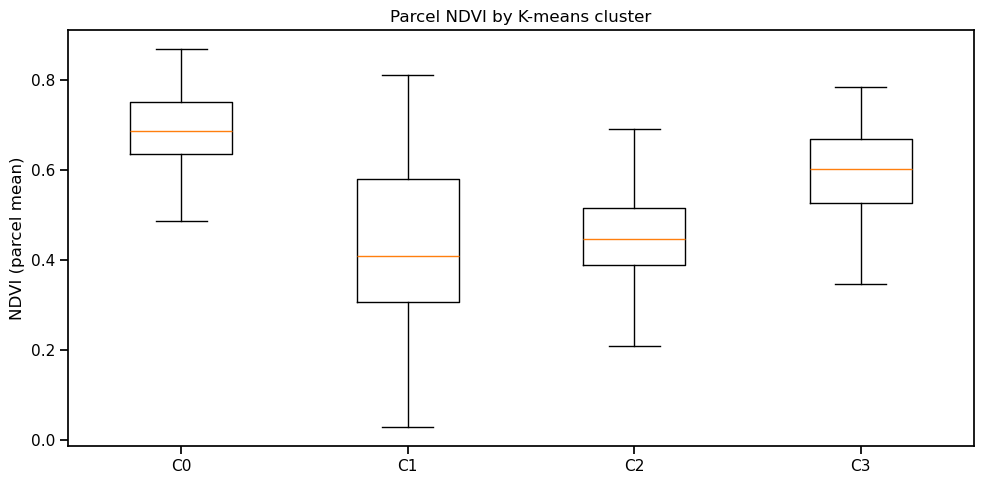

In [156]:
# NDVI-4 — join to K-means clusters; summarize + boxplot by cluster
import matplotlib.pyplot as plt
import numpy as np

assert not ndvi_df.empty, "No NDVI stats computed."

lab_df = comp_df[[join_key, "cluster_km"]].drop_duplicates(subset=[join_key])
ndvi_join = ndvi_df.merge(lab_df, on=join_key, how="inner")

# cluster summary
ndvi_cluster_stats = (ndvi_join
                      .groupby("cluster_km")[["ndvi_mean","ndvi_median","ndvi_p10","ndvi_p90"]]
                      .agg(["mean","median"])
                      .round(3))
display(ndvi_join.head(10))
display(ndvi_cluster_stats)

# boxplot of parcel NDVI mean by cluster
clusters = sorted(ndvi_join["cluster_km"].unique())
data = [ndvi_join.loc[ndvi_join["cluster_km"]==k, "ndvi_mean"].to_numpy() for k in clusters]

plt.figure(figsize=(10,5))
plt.boxplot(data, labels=[f"C{k}" for k in clusters], showfliers=False)
plt.ylabel("NDVI (parcel mean)")
plt.title("Parcel NDVI by K-means cluster")
plt.tight_layout()


C:\Users\jbros\AppData\Local\Temp\ipykernel_23432\201725884.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  comp_wide = comp_long.pivot_table(index='site_id', columns='height_bin', values=METRIC_USED, aggfunc='sum', fill_value=0.0)


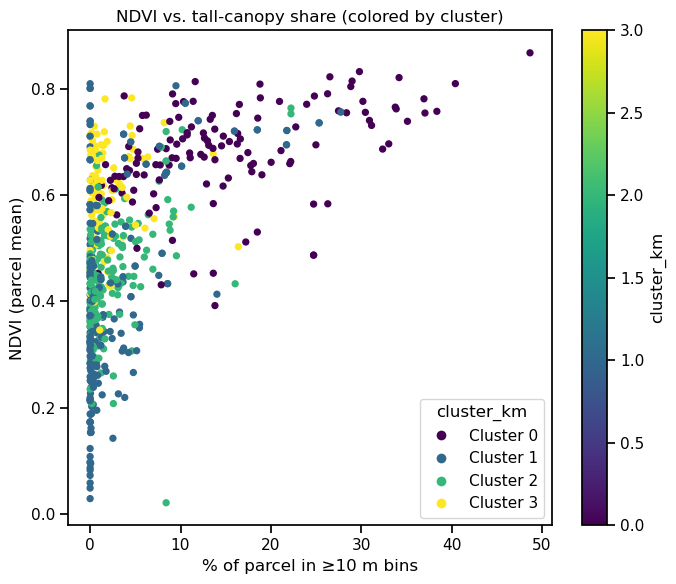

In [158]:
# NDVI-5 — NDVI vs. tall-canopy share (colored by cluster, viridis + legend)

# need comp_cols (height-bin order) and out_df to compute tall_share
assert 'comp_cols' in globals(), "Need comp_cols (height-bin columns)."
METRIC_USED = "pct_of_parcel_%"

comp_long = out_df[['site_id','height_bin',METRIC_USED]].copy()
comp_long = comp_long[comp_long['height_bin'].isin(comp_cols)]
comp_wide = comp_long.pivot_table(index='site_id', columns='height_bin', values=METRIC_USED, aggfunc='sum', fill_value=0.0)

# compute tall share (>=10 m bins) using bin mids
bin_mids = np.array([(float(b.split('–')[0]) + float(b.split('–')[1].split()[0]))/2.0 for b in comp_cols])
tall_mask = bin_mids >= 10.0
tall_share = comp_wide.iloc[:, np.where(tall_mask)[0]].sum(axis=1)

plot_tbl = ndvi_join.merge(tall_share.rename('tall_share_pct').reset_index(), on='site_id', how='left')

from matplotlib.lines import Line2D
plt.figure(figsize=(7,6))
sc = plt.scatter(plot_tbl['tall_share_pct'], plot_tbl['ndvi_mean'],
                 c=plot_tbl['cluster_km'], s=18, cmap='viridis')
plt.xlabel("% of parcel in ≥10 m bins")
plt.ylabel("NDVI (parcel mean)")
plt.title("NDVI vs. tall-canopy share (colored by cluster)")

plt.colorbar(sc, label="cluster_km")

# categorical legend
uniq = sorted(pd.unique(plot_tbl['cluster_km']))
handles = [Line2D([0],[0], marker='o', linestyle='', markersize=7,
                  markerfacecolor=sc.cmap(sc.norm(k)), markeredgecolor='none',
                  label=f"Cluster {int(k)}") for k in uniq]
plt.legend(handles=handles, title="cluster_km", loc="best", frameon=True)

plt.tight_layout()

